In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.linear_model import LinearRegression
from prophet import Prophet

In [4]:
# загрузим данные в датасет
df = pd.read_csv('data/ghana_gdp.csv', index_col='year', parse_dates=['year'])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


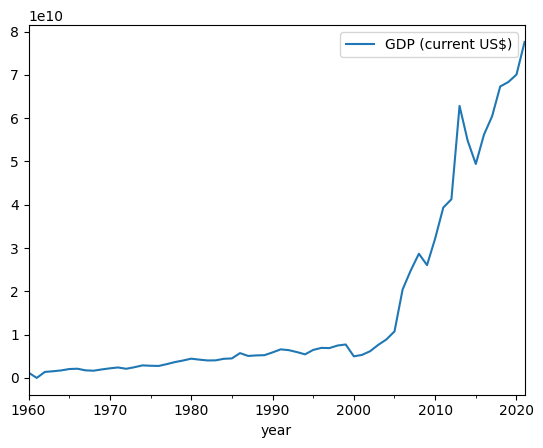

In [6]:
#визуализуем исходный временной ряд
df.plot();

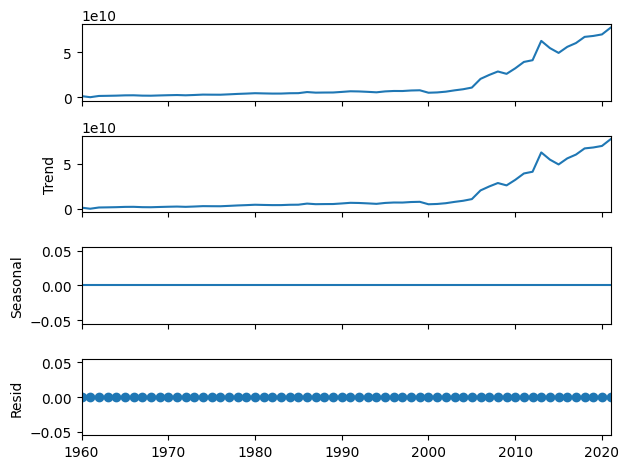

In [7]:
# посмотрим на линию треда и сезонность
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

**Выводы:** 
- в данных существует тренд, причем сильно наблюдается после 2000 года;
- в данных отсутствует сезонность, признак q для моделей возьмем равным 0.

In [18]:
# разделим данные на обучающую и тестовую выборки
train_df = df.loc[:'2018-12-31']
test_df = df.loc['2019-01-01':]
train_df.shape, test_df.shape

((59, 1), (3, 1))

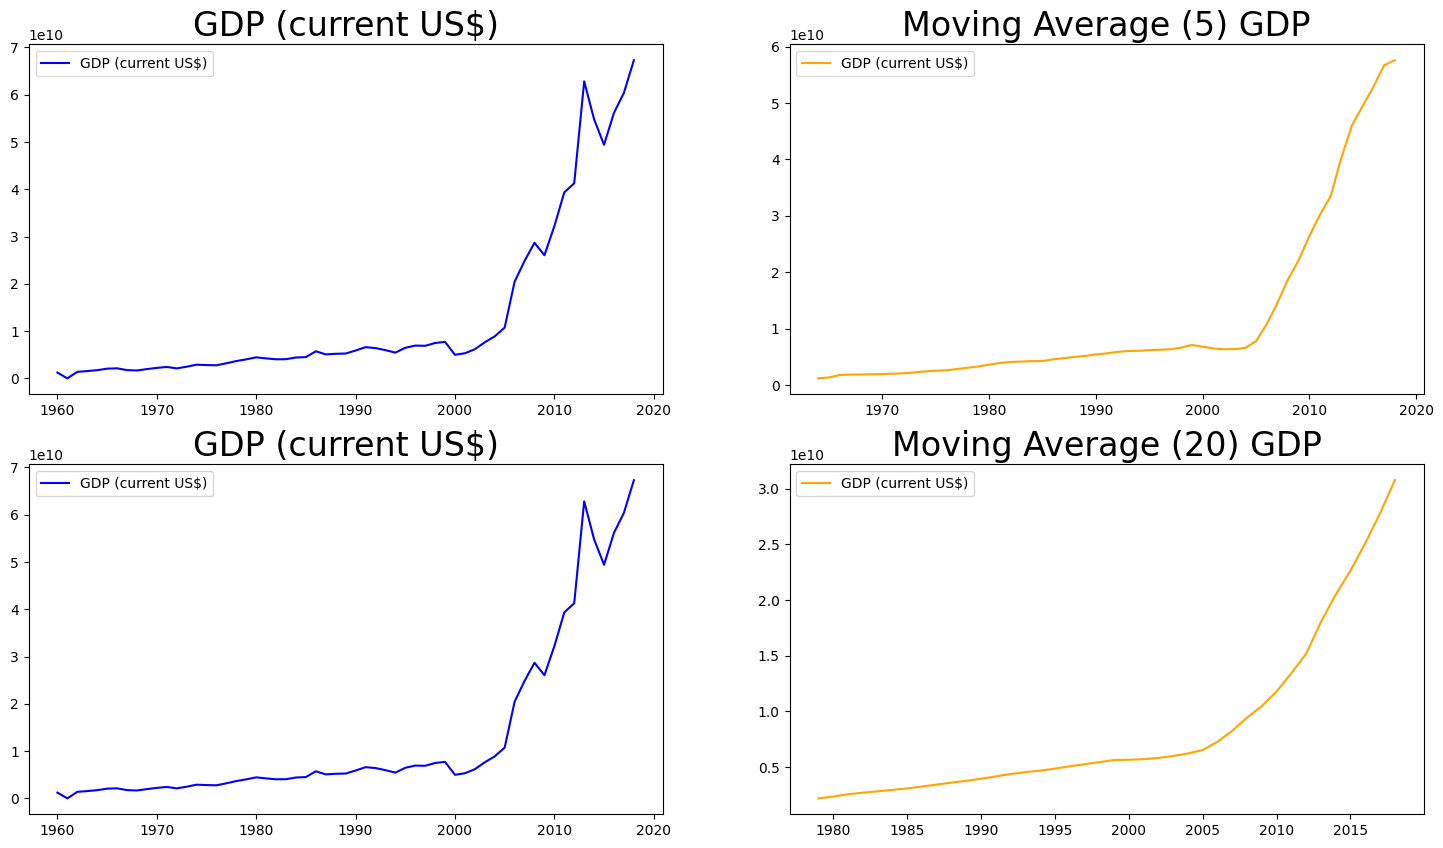

In [22]:
# построим скользящие графики
plt.rcParams['figure.figsize'] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label='GDP (current US$)')
ax[0, 0].set_title('GDP (current US$)', size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color='orange',
    label='GDP (current US$)',
)

ax[0, 1].set_title('Moving Average (5) GDP', size=24)
ax[0, 1].legend()

ax[1, 0].plot(train_df['GDP (current US$)'], color='blue', label='GDP (current US$)')
ax[1, 0].set_title('GDP (current US$)', size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=20).mean(),
    color='orange',
    label='GDP (current US$)',
)

ax[1, 1].set_title('Moving Average (20) GDP', size=24)
ax[1, 1].legend()

plt.show()

**Вывод:** тренд на графиках хорошо наблюдается, до 2000 года тренд был не такой сильный, а после 2000 года наблюдается значительный рост.

In [23]:
# проверим стационарность на исходных данных
test = adfuller(train_df)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд не является стационарным


In [26]:
# продифференцируем данные
df_diff_1 = train_df.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд не является стационарным


In [27]:
# продифференцируем данные еще раз
df_diff_2 = df_diff_1.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_2)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -2.640869056128483
p-value:  0.08484116917837797
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд не является стационарным


In [28]:
# продифференцируем данные еще раз
df_diff_3 = df_diff_2.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_3)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -4.779623784828528
p-value:  5.9483276402250296e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд является стационарным


**Вывод:** нам потребуется модель 3 порядка, то есть параметр d для моделей равен 3.

In [34]:
# напишем функцию для построения графиков полной и частичной автокорреляции
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1], method="ywm")
    plt.show()

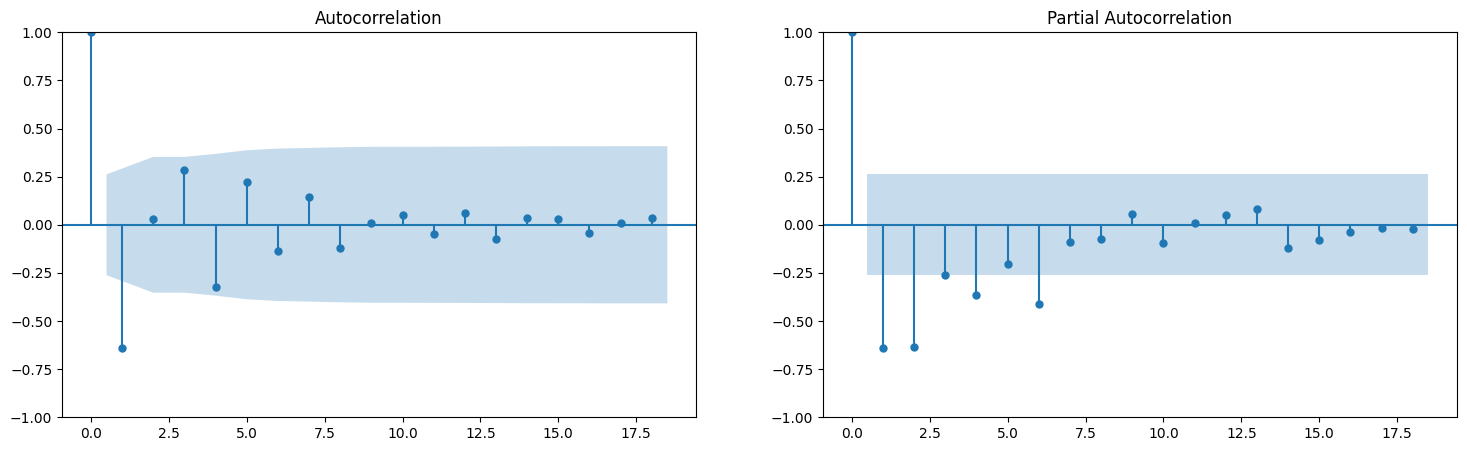

In [35]:
# построим графики полной и частичной автокорреляции
plot_acf_pacf(df_diff_3)

**Вывод:** согласно графику pacf лаг составит 6, то есть параметр p для моделей равен 6.

In [37]:
# построим модель ARIMA на подобранных параметрах
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(6, 3, 0))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 0)   Log Likelihood               -1309.912
Date:                Fri, 21 Jun 2024   AIC                           2633.824
Time:                        16:20:27   BIC                           2648.002
Sample:                    01-01-1960   HQIC                          2639.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6340      0.061    -26.958      0.000      -1.753      -1.515
ar.L2         -2.1130      0.127    -16.681      0.000      -2.361      -1.865
ar.L3         -2.0519      0.141    -14.581      0.000      -2.328      -1.776
ar.L4         -2.0483      0.120    -17.031      0.000      -2.284      -1.813
ar.L5         -1.5283      0.127    -12.045      0.000      -1.777      -1.280
ar.L6         -0.9291      0.067    -13.939      0.000      -1.060      -0.798
sigma2      8.669e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                98.19
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              56.28   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+54. Standard errors may be unstable.
"""

**Вывод:** метрика AIC составила 2633.824

In [39]:
# попробуем подобрать параметры с помощью pmdarima
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=8,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.03 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.00 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.12 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.04 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.679 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 21 Jun 2024   AIC                           2659.231
Time:                        16:31:00   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+56. Standard errors may be unstable.
"""

**Вывод:** метрика AIC составила 2659.231, что больше, чем показатель, который получился с вручную подобранными параметрами.

In [69]:
# построим еще 1 модель на подобранных параметрах
arima_model_opt = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 3, 1))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Fri, 21 Jun 2024   AIC                           2670.910
Time:                        17:53:30   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+55. Standard errors may be unstable.
"""

**Вывод:** все равно метерика AIC получается больше, чем при ручном подборе.

In [73]:
# сделаем предсказание и построим доверительный интервал на данных из подобранных с помощью pmdarima
pred_df = pd.DataFrame(index=df.index)
pred_df["model_preds"] = arima_model_opt_fit.predict(start=test_df.index[0], end=test_df.index[-1])

pred_df['GDP (current US$)'] = df['GDP (current US$)']
forecast = arima_model_opt_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']
pred_df

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.305428e+10,6.833754e+10,6.054082e+10,8.556773e+10


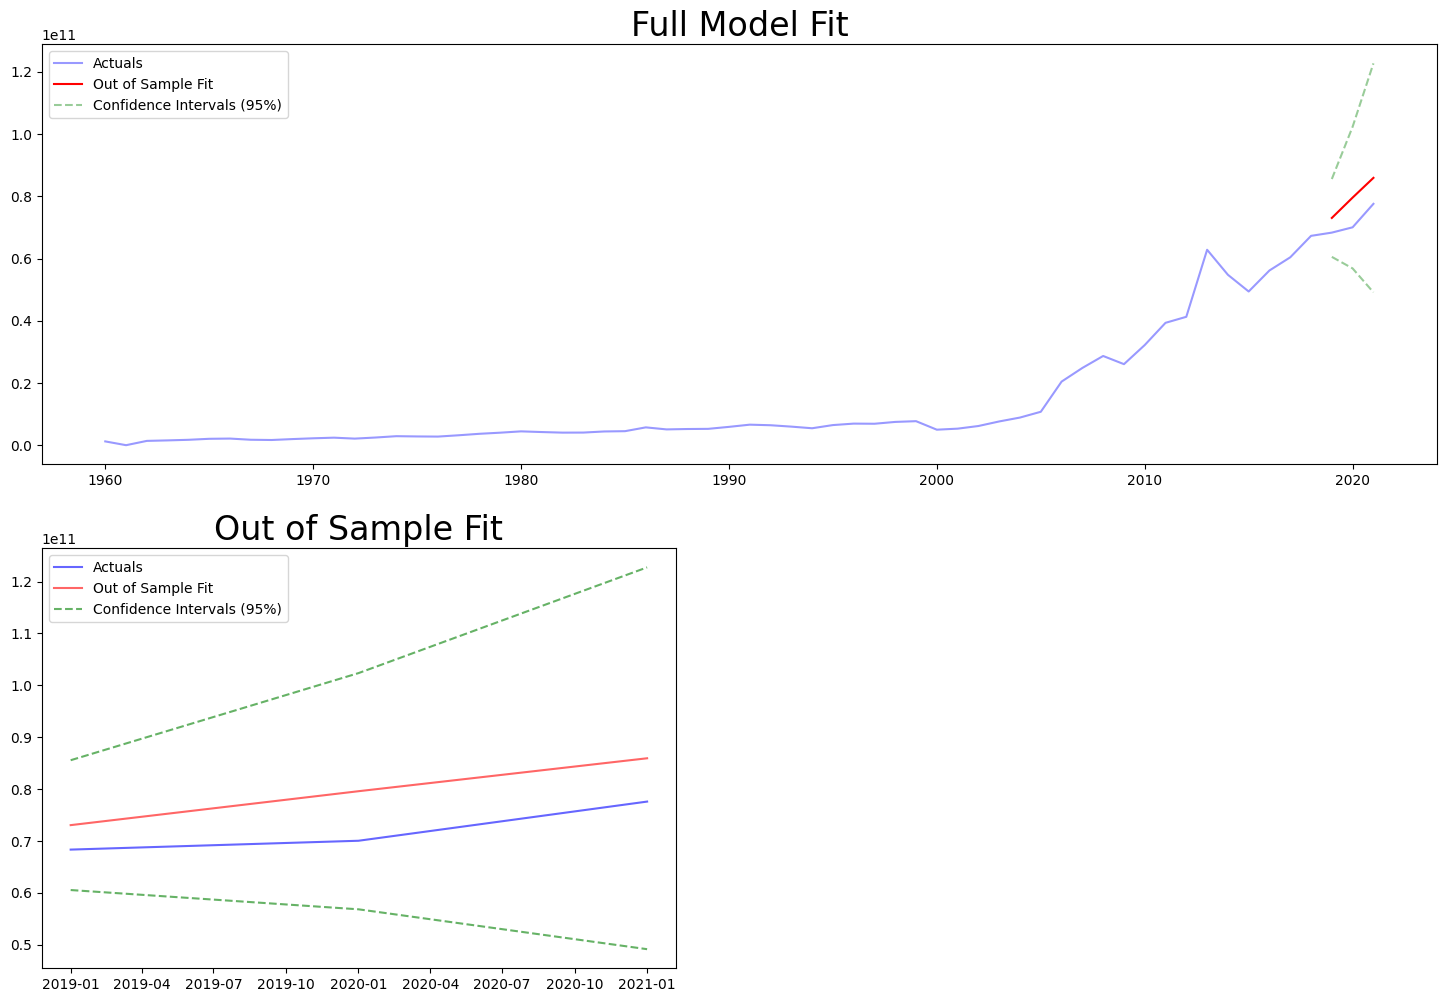

In [72]:
# отобразим прогноз и доверительный интервал на графике
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['GDP (current US$)'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

**Вывод:** подобранные параметры с сезонностью лучше определяю прогноз, однако при этом сезонность в данных не наблюдается. Построенный прогноз чуть выше, чем фактиечские значения, но сохраняется тренд. Фактические данные входят в 95-% доверительный интервал.

In [78]:
# проверим наличие проупсков в индексах дат
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


**Вывод:** пустых индексов нет.

In [75]:
# проверим наличие пропусков в данных
df['GDP (current US$)'].isna().sum()

0

**Вывод:** пропусков в данных нет.

In [79]:
# проверим наличие значения 0 в данных
df[df['GDP (current US$)'] == 0]

,GDP (current US$)
year,
1961-01-01,0.0


**Вывод:** есть одно нулевое значение. Заменим его.

In [80]:
# заменим нулевое значение на NaN
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [85]:
# применим интерполяцию для значения NaN
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [97]:
# посмотрим на заполненное значение после интерполяции
df['GDP (current US$)'].loc['1961-01-01'].round()

1299719888.0

In [87]:
# перепроверим пропуски
df['GDP (current US$)'].isna().sum()

0

In [89]:
# разделим данные на обучающую выборку повторно
train_df = df.loc[:'2018-12-31']

In [90]:
# проверим стационарность на исходных данных
test = adfuller(train_df )
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд не является стационарным


In [91]:
# продифференцируем данные
df_diff_1 = train_df.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -1.8255652246436056
p-value:  0.3678451527656314
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд не является стационарным


In [92]:
# продифференцируем данные еще раз
df_diff_2 = df_diff_1.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_2)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -2.634634746007848
p-value:  0.08604813722197563
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд не является стационарным


In [93]:
# продифференцируем данные еще раз
df_diff_3 = df_diff_2.diff().dropna()
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff_3)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -4.825603687304028
p-value:  4.8573180767997966e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд является стационарным


**Вывод:** нам потребуется модель 3 порядка, то есть параметр d для моделей равен 3. Хотя можно попробовать и модель 2 порядка, так как adf меньше 10-% критического значения.

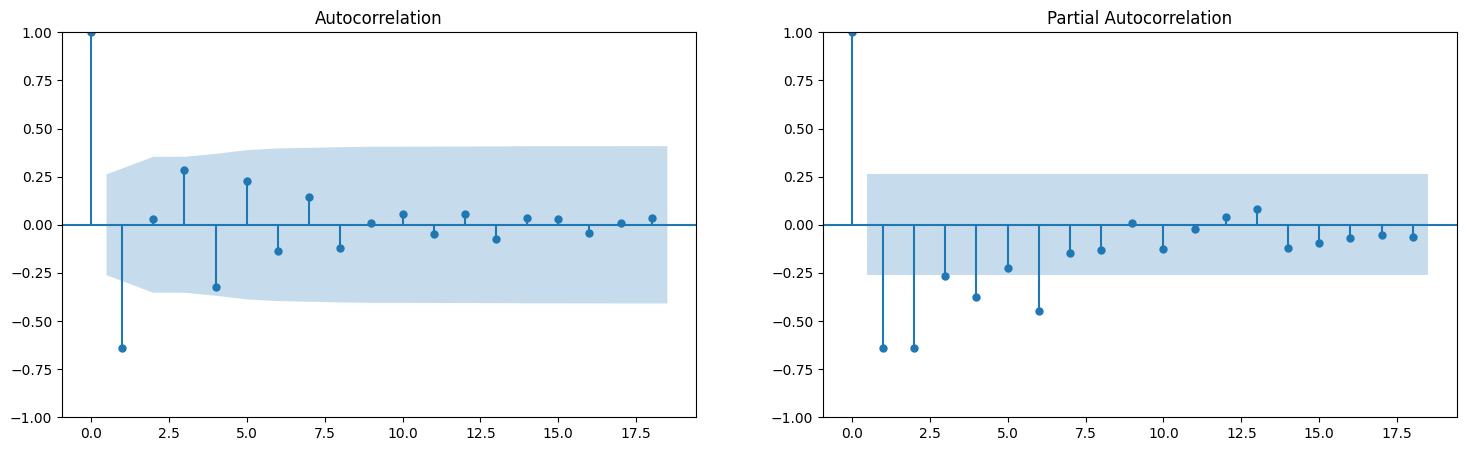

In [94]:
# построим графики полной и частичной автокорреляции
plot_acf_pacf(df_diff_3)

**Вывод:** согласно графику pacf лаг составит 6, то есть параметр p для моделей равен 6.

In [95]:
# построим модель ARIMA на обновленных параметрах
arima_model_new = ARIMA(train_df['GDP (current US$)'].dropna(), order=(6, 3, 0))
arima_model_new_fit = arima_model.fit()
arima_model_new_fit.summary()

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 0)   Log Likelihood               -1309.912
Date:                Fri, 21 Jun 2024   AIC                           2633.824
Time:                        22:29:34   BIC                           2648.002
Sample:                    01-01-1960   HQIC                          2639.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6340      0.061    -26.958      0.000      -1.753      -1.515
ar.L2         -2.1130      0.127    -16.681      0.000      -2.361      -1.865
ar.L3         -2.0519      0.141    -14.581      0.000      -2.328      -1.776
ar.L4         -2.0483      0.120    -17.031      0.000      -2.284      -1.813
ar.L5         -1.5283      0.127    -12.045      0.000      -1.777      -1.280
ar.L6         -0.9291      0.067    -13.939      0.000      -1.060      -0.798
sigma2      8.669e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                98.19
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              56.28   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+54. Standard errors may be unstable.
"""

**Вывод:** заполнение 1 пропущенного значения не принесло каких-либо изменений в определении параометров модели и улучшения метрика AIC.

In [102]:
# посчитаем волатильность временного ряда
df['GDP_vol'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df['GDP_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

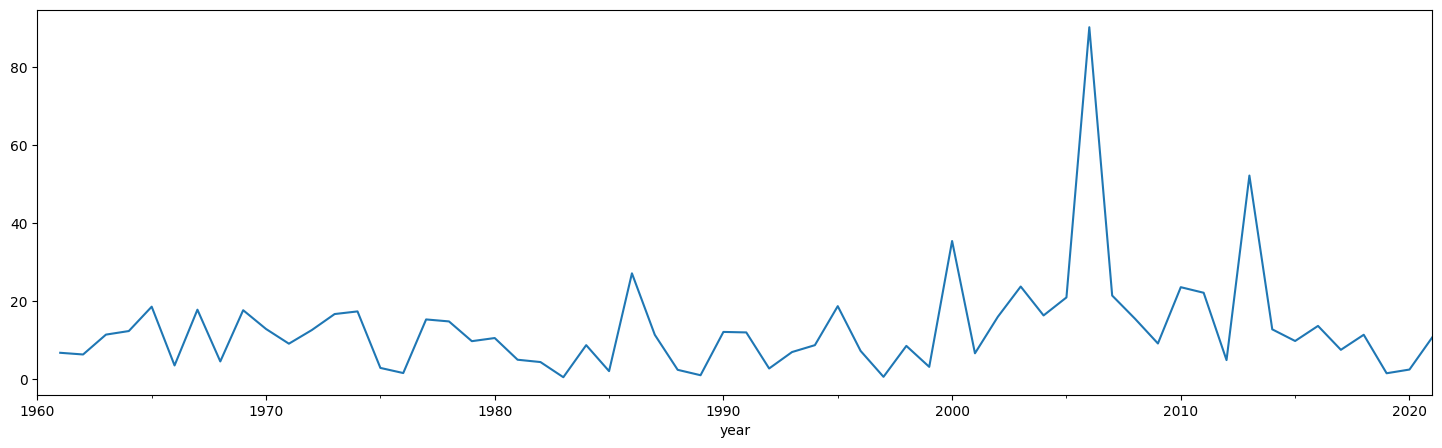

In [103]:
# построим график волотильности
df['GDP_vol'].plot()
plt.show()

**Вывод:** волатильность в данных присутствует, местами наблюдаются значительные выбросы, начиная с 2000 года.

In [104]:
# разделим данные на обучающую и тестовую выборки
train_df = df.loc[:'2018-12-31']
test_df = df.loc['2019-01-01':]
train_df.shape, test_df.shape

((59, 2), (3, 2))

In [106]:
# проверим стационарность на исходных данных
test = adfuller(train_df['GDP_vol'][1:])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Ряд является стационарным


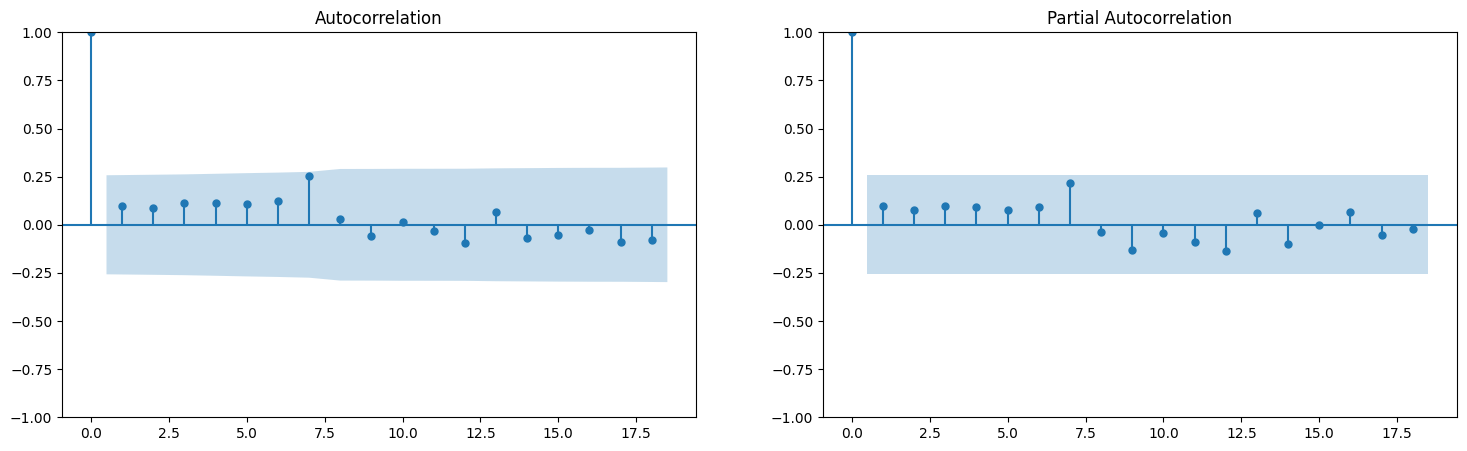

In [109]:
# построим графики полной и частичной автокорреляции
plot_acf_pacf(train_df['GDP_vol'][1:])

**Вывод:** глядя на график частичной автокорреляции, самым значимым лагом является 7.

In [110]:
garch_df = pd.DataFrame(df["GDP_vol"].loc[df.index])
garch_df

,GDP_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


In [179]:
model = arch_model(garch_df['GDP_vol'].dropna(), p=7, q=1, o=1, power=0.5, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0])

Iteration:      1,   Func. Count:     13,   Neg. LLF: 510.13493798078144
Iteration:      2,   Func. Count:     31,   Neg. LLF: 446.50498114806163
Iteration:      3,   Func. Count:     44,   Neg. LLF: 252.86061742900839
Iteration:      4,   Func. Count:     57,   Neg. LLF: 216.33326421003565
Iteration:      5,   Func. Count:     69,   Neg. LLF: 229.5021807431215
Iteration:      6,   Func. Count:     82,   Neg. LLF: 216.8943012387938
Iteration:      7,   Func. Count:     95,   Neg. LLF: 216.12041500620552
Iteration:      8,   Func. Count:    108,   Neg. LLF: 215.30927996572387
Iteration:      9,   Func. Count:    121,   Neg. LLF: 215.02194841421345
Iteration:     10,   Func. Count:    134,   Neg. LLF: 214.37522018126464
Iteration:     11,   Func. Count:    146,   Neg. LLF: 216.37480229261112
Iteration:     12,   Func. Count:    159,   Neg. LLF: 219.42676284358262
Iteration:     13,   Func. Count:    172,   Neg. LLF: 224.4815469668377
Iteration:     14,   Func. Count:    185,   Neg. LLF: 

In [180]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 0.5) Model Results               
==========================================================================================
Dep. Variable:                            GDP_vol   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 0.5)   Log-Likelihood:               -213.810
Distribution:                              Normal   AIC:                           449.620
Method:                        Maximum Likelihood   BIC:                           472.285
                                                    No. Observations:                   58
Date:                            Sat, Jun 22 2024   Df Residuals:                       57
Time:                                    23:49:35   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.6107      0.167     75.310      0.000 [ 12.283, 12.939]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6892      2.309      0.299      0.765 [ -3.836,  5.214]
alpha[1]       0.1677      0.876      0.191      0.848 [ -1.549,  1.884]
alpha[2]   1.3261e-15      0.566  2.343e-15      1.000 [ -1.109,  1.109]
alpha[3]       0.0650      0.252      0.258      0.797 [ -0.430,  0.560]
alpha[4]   6.2679e-14      0.241  2.597e-13      1.000 [ -0.473,  0.473]
alpha[5]   8.3688e-16      0.154  5.450e-15      1.000 [ -0.301,  0.301]
alpha[6]       0.4957      0.200      2.480  1.314e-02 [  0.104,  0.887]
alpha[7]       0.1740      0.196      0.886      0.376 [ -0.211,  0.559]
gamma[1]       0.1953      0.249      0.784      0.433 [ -0.293,  0.684]
beta[1]    2.5669e-15      0.320  8.017e-15      1.000 [ -0.628,  0.628]
========================================================================

Covariance estimator: robust
"""

In [181]:
# сделаем предсказание
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]
predictions_df

,GDP (current US$),GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,126.361123
2020-01-01,7.004320e+10,2.495937,63.164323
2021-01-01,7.759428e+10,10.780603,23.426936


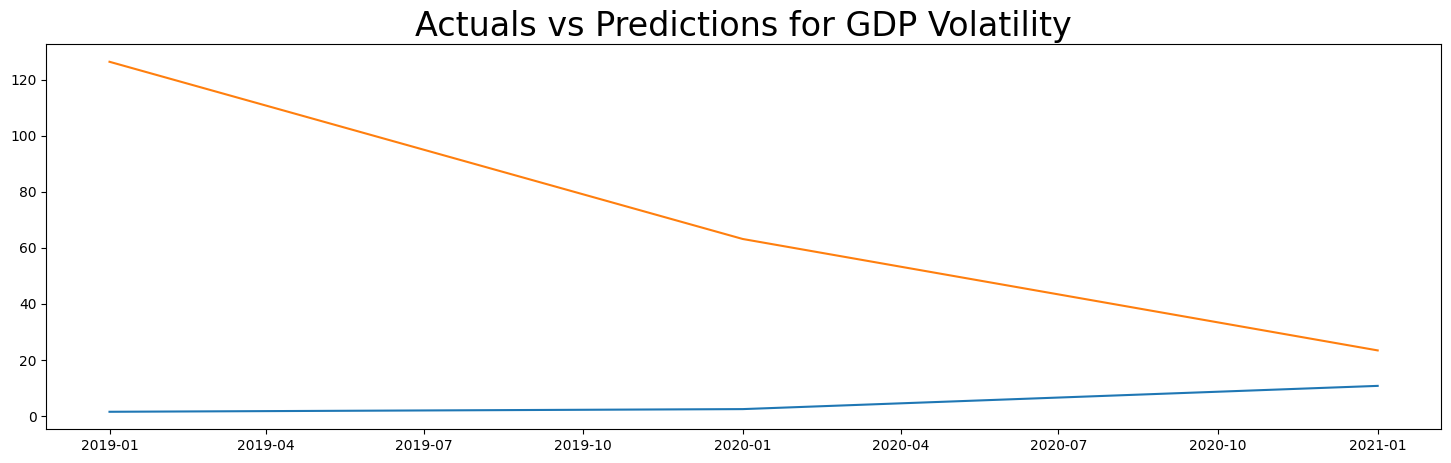

In [182]:
# построим график сравнения фактического и предсказанного значения
plt.rcParams['figure.figsize'] = 18, 5

plt.plot(predictions_df['GDP_vol'].abs())
plt.plot(predictions_df["Predictions"])

plt.title('Actuals vs Predictions for GDP Volatility', size=24)
plt.show();

**Вывод:** фактические и предсказанные значения сильно разошлись скорее всего из-за короткого периода временного ряда, а так же наличия гетероскедастичности временного ряда.

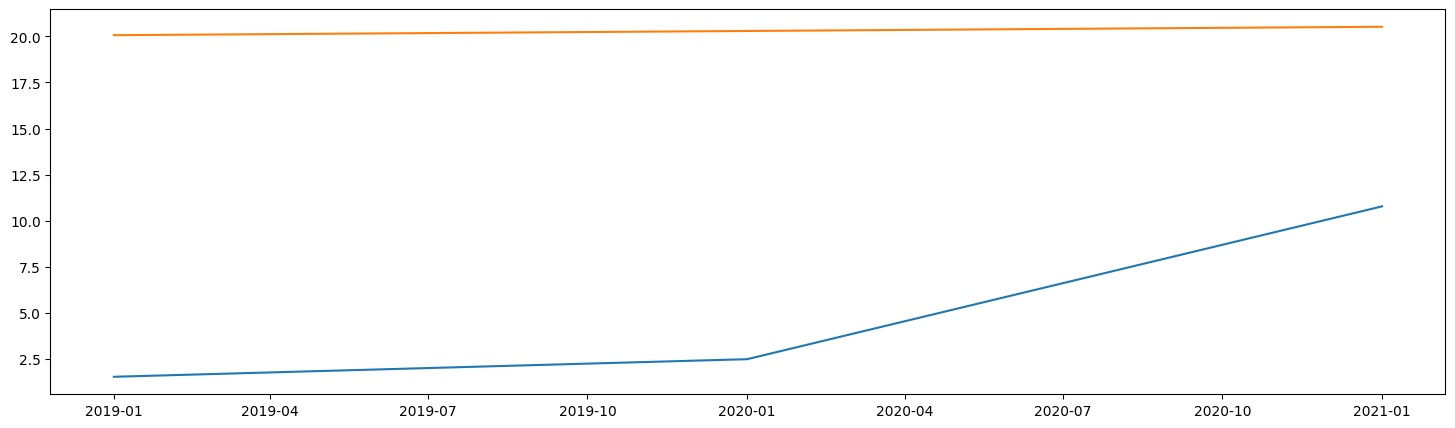

In [143]:
# построим модель линейной регрессии
X_train = pd.DataFrame(range(df['GDP_vol'].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['GDP_vol'].shape[0]))[
    train_df.shape[0] :
].fillna(0)

y_train = train_df['GDP_vol'].fillna(0)
y_test = test_df['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
 
# визуализируем результаты    
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

**Вывод:** модель линейной регрессии так же не уловила волотильность, но при этом результат получился более близким. 